In [1]:
!pip install transformers datasets bertviz -q
!pip install accelerate -U


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.8 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from transformers import pipeline, set_seed, GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer
from torch import tensor, numel
from bertviz import model_view

set_seed(42)

In [3]:
from transformers import pipeline, set_seed
from torch import tensor

generator = pipeline('text-generation', model='gpt2', tokenizer=tokenizer)
set_seed(0)

NameError: name 'tokenizer' is not defined

In [ ]:
# Bias
generator("The holocaust was", max_length=10, num_return_sequences=10)

## Few-shot learning

In [ ]:
print(generator("""Sentiment Analysis
Text: I hate it when my phone battery dies.
Sentiment: Negative
###
Text: My day has been really great!
Sentiment: Positive
###
Text: Not a fan when it is cloudy
Sentiment:""", top_k=2, temperature=0.1, max_length=55)[0]['generated_text'])

In [ ]:
print(generator("""Question/Answering
C: Google was founded in 1998 by Larry Page and Sergey Brin while they were Ph.D. students at Stanford University in California. Together they own about 14 percent of its shares and control 56 percent of the stockholder voting power through supervoting stock.
Q: When was Google founded?
A: 1998
###
C: Hugging Face is a company which develops social AI-run chatbot applications. It was established in 2016 by Clement Delangue and Julien Chaumond. The company is based in Brooklyn, New York, United States.
Q: What does Hugging Face develop?
A: social AI-run chatbot applications
###
C: The New York Jets are a professional American football team based in the New York metropolitan area. The Jets compete in the National Football League (NFL) as a member club of the league's American Football Conference (AFC) East division.
Q: What division do the Jets play in?
A:""", top_k=5, num_beams=2, max_length=215, temperature=0.5)[0]['generated_text'])

In [ ]:
## ## Zero Shot Learning

In [ ]:
# Same question as before, with no previous examples ie Zero-shot learning. Hit or miss
print(generator(
    '''Question/Answering
C: The New York Jets are a professional American football team based in the New York metropolitan area. The Jets compete in the National Football League (NFL) as a member club of the league's American Football Conference (AFC) East division.
Q: What division do the Jets play in?
A:''',
    top_k=5, num_beams=2, max_length=80, temperature=0.5)[0]['generated_text']
)

In [ ]:
!pip install evaluate -q

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
import evaluate
import numpy as np
from datasets import load_metric, load_dataset
import random

In [6]:
# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)

In [7]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [8]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [9]:
MODEL = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [10]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):  # each example is an element from the Dataset
    return tokenizer(examples["review"], truncation=True)

In [11]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
sequence_clf_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=5,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/57613 [00:00<?, ? examples/s]

In [14]:
dataset = dataset.rename_column("star", "label")
dataset = dataset.remove_columns(['package_name', 'review', 'date'])
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

<Axes: >

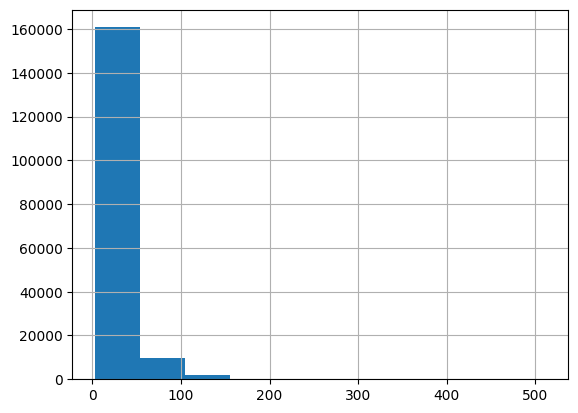

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

input_ids = dataset['train']['input_ids']
pd.Series(input_ids).apply(len).hist()

In [16]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

In [17]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./bert_clf_results",
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_ratio=0.1,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,  # optional
    data_collator=data_collator  # technically optional
)

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.6808284521102905,
 'eval_accuracy': 0.11047853783000365,
 'eval_runtime': 39.5282,
 'eval_samples_per_second': 1457.516,
 'eval_steps_per_second': 45.562}

In [19]:
trainer.train()

***** Running training *****
  Num examples = 172,839
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 10,802
  Number of trainable parameters = 65,785,349


Epoch,Training Loss,Validation Loss,Accuracy
0,0.572200,0.827350,0.712686
1,0.818400,0.822340,0.717460


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
Saving model checkpoint to ./bert_clf_results/tmp-checkpoint-5401
Configuration saved in ./bert_clf_results/tmp-checkpoint-5401/config.json
Model weights saved in ./bert_clf_results/tmp-checkpoint-5401/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
Saving model checkpoint to ./bert_clf_results/tmp-checkpoint-10802
Configuration saved in ./bert_clf_results/tmp-checkpoint-10802/config.json
Model weights saved in ./bert_clf_results/tmp-checkpoint-10802/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./bert_clf_results/checkpoint-10802 (score: 0.8223401308059692).


TrainOutput(global_step=10802, training_loss=0.8275805247881703, metrics={'train_runtime': 735.9695, 'train_samples_per_second': 469.691, 'train_steps_per_second': 14.677, 'total_flos': 7015951744063140.0, 'train_loss': 0.8275805247881703, 'epoch': 2.0})